In [1]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from datetime import datetime
from qutip import sigmax, sigmay, sigmaz, jmat
import time
import h5py
from labellines import labelLine, labelLines
from time import sleep


import matplotlib.animation as animation

In [2]:
from spin_reconstruction.constants import *

In [3]:
erbium_gamma[2]

np.float64(-1.1564689844006002e-23)

In [4]:
a_par_weight = 0 # A_par/C_zz ~ 50k

file = "reconstructed_apar_sweep_all0.hdf5"
couplings_file = "couplings_quarter_full.hdf5"

keep_partial_solutions = False

max_distance = 9
target_B = np.array([0,0.9])/180*np.pi

# State reconstruction

In [5]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )

In [6]:
  
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

###  Load data

In [7]:
from measurement_data import data_header, renormalized_data, a_par_data, nb_par_data

### Compute

In [8]:
with (
    h5py.File(file, "r") as g,
    h5py.File(couplings_file, "r") as f
):
    all_final_sites = []
    all_errors = []
    all_B = []
    all_permutations = []
    all_keys = []
    a_par_keys = []
    for a_par_key, gg in tqdm(g.items()):
        
        if a_par_key.startswith("measured"):
            continue
        i = 0
        x_size = f.attrs["x_end"] - f.attrs["x_start"]
        y_size = f.attrs["y_end"] - f.attrs["y_start"]
        all_errors.append(np.empty(x_size * y_size))
        all_B.append(np.empty((x_size * y_size,3)))
        all_final_sites.append(np.empty((x_size * y_size, len(a_par_data)), dtype = np.uint64))
        all_permutations.append(np.empty((x_size * y_size, len(a_par_data)), dtype = np.uint64))
        all_keys.append([])
        a_par_keys.append(a_par_key)
        for k, v in gg.items():
            B = v.attrs["B"]
            key = k.removeprefix("Reconstructed_from_")
            final_site = v["sites"][0]
            permutation = v["permutation"][:]
            permutation_inv = invert_permutation(permutation.copy())
    
            if "ended_prematurely" in v.attrs and v.attrs["ended_prematurely"] and not keep_partial_solutions:
                continue
            
            all_keys[-1].append(key)
            all_errors[-1][i] = v["errors"][0]
            all_final_sites[-1][i] = final_site[permutation_inv]
            all_permutations[-1][i] = permutation
            all_B[-1][i] = v.attrs["B"]
            i += 1
        all_errors[-1] = all_errors[-1][:i]
        all_B[-1] = all_B[-1][:i]
        all_final_sites[-1] = all_final_sites[-1][:i]
        sleep(0.05)
del final_site
del i

xy = [np.sqrt(B[:,0]**2 + B[:,1]**2) for B in all_B]

  0%|          | 0/21 [00:00<?, ?it/s]

# Results overview

[8, 2, 11, 16, 3, 12, 17, 4, 13, 18, 7, 14, 19, 9, 15, 10, 6, 5, 0, 1]
[0.69994776 0.        ]
[1783 1136 1781 1784 1816 1135 1096 1497 1460]
[0. 0.]
[1459 1784 1133 1136 1168 2107 1744 1497 1460]
[0.69994776 0.        ]
[1459 1747 1169 1136 1096 1748 1816 1497 1460]
[0.69994776 0.        ]
[1459 1747 2078 1136 1822 1748 2214 1497 1460]
059

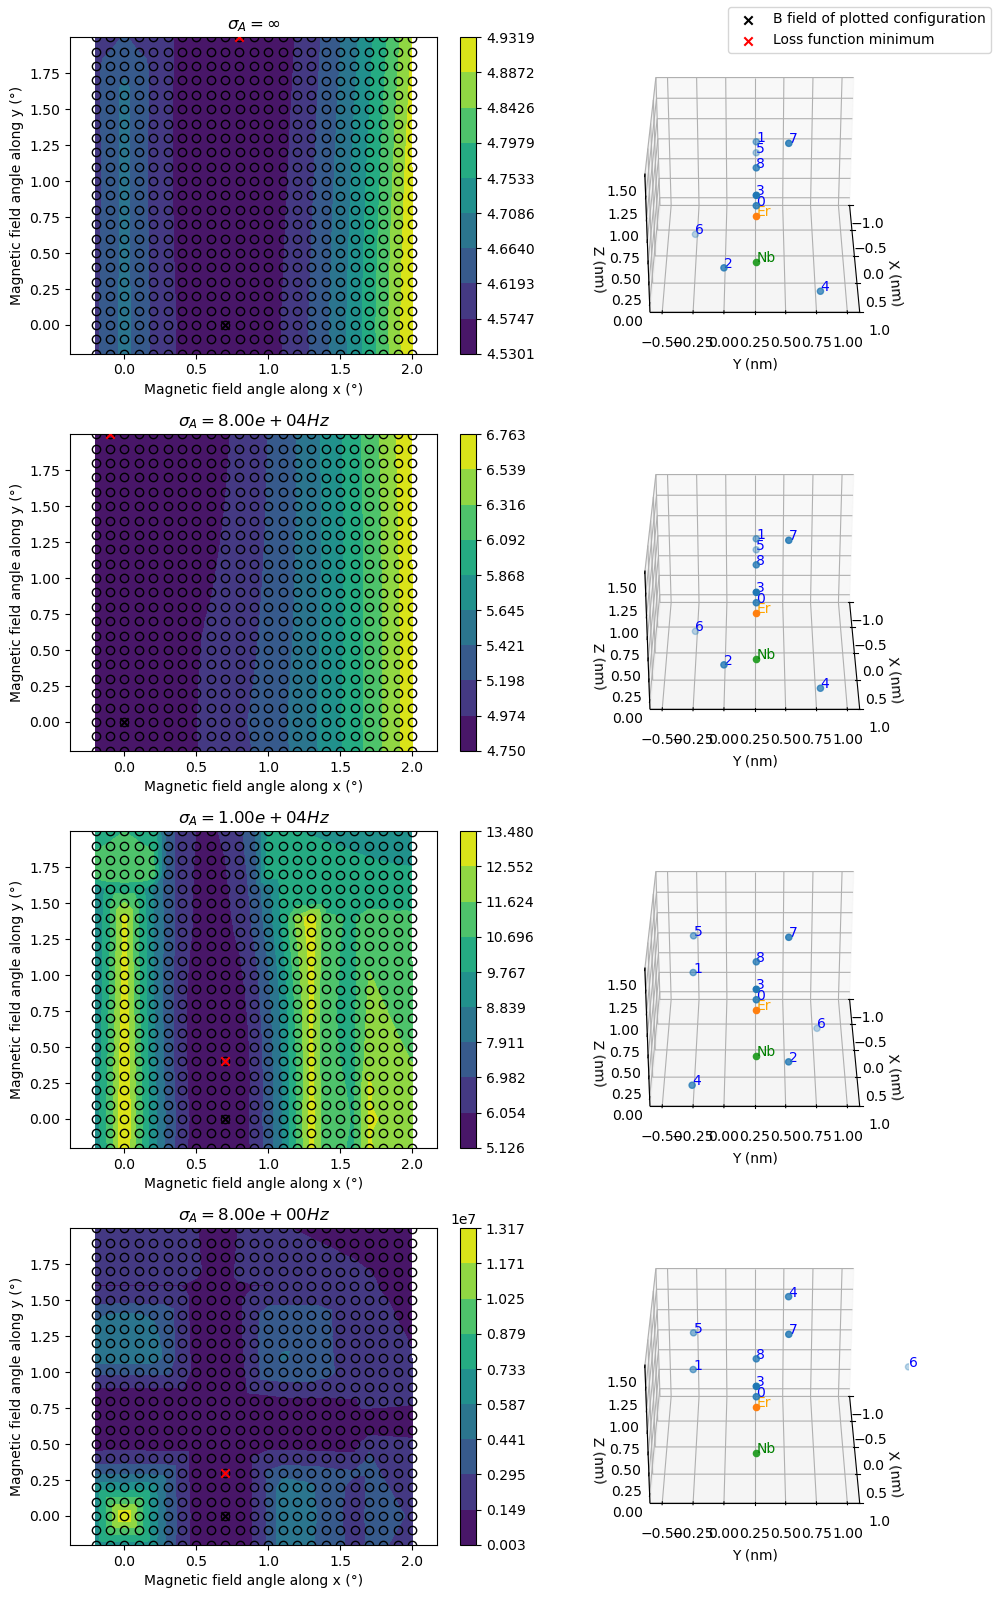

In [11]:
%matplotlib inline

theta = 0*np.pi/8
target_B = 0*np.array([np.cos(theta),np.sin(theta)])/180*np.pi


selected_apar = [0,10,15,19]

fig = plt.figure(figsize=(10,4*len(selected_apar)))
#fig.suptitle("Minimal loss function as a function of the applied B field\nfor different value")
sort_a_par_w = sorted(range(len(a_par_keys)), key=lambda i: float(a_par_keys[i].removeprefix("Reconstructed_weight_")))
no_a_par_index = sort_a_par_w[0]


print(sort_a_par_w)
artists = []
axes = []
j = 0
for k, i in enumerate(sort_a_par_w):
    if k not in selected_apar:
        continue
    ax = fig.add_subplot(len(selected_apar),2,2*j+1)
    ax3d = fig.add_subplot(len(selected_apar),2,2*j+2,projection='3d')
    
    
    ax.plot(all_B[i][:,0]*180/np.pi, all_B[i][:,1]*180/np.pi, 'o', color="black", mfc='none')
    sc = ax.tricontourf(all_B[i][:,0]*180/np.pi, all_B[i][:,1]*180/np.pi, all_errors[i], levels=np.linspace(np.min(all_errors[i]), np.max(all_errors[i]), 10))

    sorted_errors_index = np.argsort(all_errors[i])
    index = 0
    while np.abs(all_B[i][sorted_errors_index[index],1]*180/np.pi) >= 0.001:
        index += 1
    target_B = all_B[i][sorted_errors_index[index],:2]
    print(target_B*180/np.pi)
    
    n = np.argmin(all_errors[i])
    minimum_scatter = ax.scatter(all_B[i][n,0]*180/np.pi, all_B[i][n,1]*180/np.pi, c="red", marker="x", zorder=1000)

    fref = float(a_par_keys[i].removeprefix("Reconstructed_weight_"))**(-0.5)
    ax.set_title(f"$\\sigma_A = {f"{fref:.2e} Hz" if fref < 1e20 else "\\infty"}$")
    
    n = np.argmin(np.linalg.norm(all_B[i][:,:2] - target_B, axis=1))
    target_scatter = ax.scatter(all_B[i][n,0]*180/np.pi, all_B[i][n,1]*180/np.pi, c="black", marker="x")
    
    ax.set_xlabel("Magnetic field angle along x (°)")
    ax.set_ylabel("Magnetic field angle along y (°)")
    ax.axis("equal")
    
    cbar = fig.colorbar(sc)

    # 3d
    b_index = np.argmin(np.linalg.norm(all_B[i][:,:2] - target_B, axis=1))
    sites = np.array([index_to_coord(all_final_sites[i][b_index][k], max_distance, 4) for k in range(len(all_final_sites[i][0]))], dtype = np.int64)
    print(all_final_sites[i][b_index])
    positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]
    # Apply symetries to get spin seven in the right quadrant:
    if positions[0][0] - 0.5 * a < 0:
        positions[:,0] = a - positions[:,0]
    if positions[7][1] - 0.5 * a < 0:
        positions[:,1] = a - positions[:,1]
    
    artists.append(ax3d.scatter(positions[:,0]*1e9, positions[:,1]*1e9, positions[:,2]*1e9))
    
    artists.append(ax3d.scatter(0.5*a*1e9, 0.5*a*1e9, 0.5*c*1e9))
    artists.append(ax3d.scatter(0.5*a*1e9, 0.5*a*1e9, 0))
    artists.append(ax3d.text(0.5*a*1e9, 0.5*a*1e9, 0.5*c*1e9, "Er", color="orange"))
    artists.append(ax3d.text(0.5*a*1e9, 0.5*a*1e9, 0, "Nb", color="green"))
    
    
    for i in range(len(positions)):
        if i ==2 and j == 3:
            continue
        artists.append(ax3d.text(positions[i,0]*1e9, positions[i,1]*1e9, positions[i,2]*1e9, str(i), color="blue"))

    ax3d.set_xlabel('X (nm)')
    ax3d.set_ylabel('Y (nm)')
    ax3d.set_zlabel('Z (nm)')
    ax3d.axis('equal')
    ax3d.set_xlim(-1,1)
    ax3d.set_ylim(-0.6,1.1)
    ax3d.set_zlim(-0.1,1.5)
    axes.append(ax3d)
    j += 1

fig.legend([target_scatter, minimum_scatter], ["B field of plotted configuration", "Loss function minimum"],
           loc="upper right")
fig.tight_layout()


def animate(i):
    for a in axes: a.view_init(azim=i)
    print(i, end = "\r")
    return (*artists,)


ani = animation.FuncAnimation(fig, animate, repeat=True, frames=360, interval=50)
writer = animation.FFMpegWriter(fps=15,
                                #metadata=dict(artist='Me'),
                                #bitrate=1800
                               )


ani.save('aparsweep.mp4', writer=writer)

# Focus on one solution

In [24]:
a_par_index = no_a_par_index
target_B = np.array((0,0.7))/180*np.pi
n = np.argmin(np.linalg.norm(all_B[a_par_index][:,:2] - target_B, axis=1))
key = all_keys[a_par_index][n]
B = all_B[a_par_index][n]

print(f"error: {np.min(all_errors[a_par_index])} @ {n}")

print(key)
with h5py.File(couplings_file, "r") as f:
    all_couplings = f[f"{key}/SEDOR_couplings"][:]
    a_parallel = f[f"{key}/A_par_couplings"][:]
    nb_par = f[f"{key}/NB_couplings"][:]

sites = np.array([index_to_coord(all_final_sites[a_par_index][n][i], max_distance, 4) for i in range(len(all_final_sites[a_par_index][0]))], dtype = np.int64)

selected_site = np.array([coord_to_index(i, max_distance, site_nb) for i in sites])

sites, key, a_par_keys[a_par_index], all_final_sites[a_par_index][n]

error: 4.530055956567919 @ 66
B_sweep_0_7


(array([[ 1,  0,  0,  3],
        [-1,  0,  1,  0],
        [ 1,  0,  0,  1],
        [ 1,  0,  1,  0],
        [ 1,  1,  0,  0],
        [-1,  0,  0,  3],
        [-1,  1,  0,  0],
        [ 0,  1,  1,  1],
        [ 0,  0,  1,  0]]),
 'B_sweep_0_7',
 'Reconstructed_weight_1.5625e-202',
 array([1783, 1136, 1781, 1784, 1816, 1135, 1168, 1497, 1460], dtype=uint64))

### Abundancy

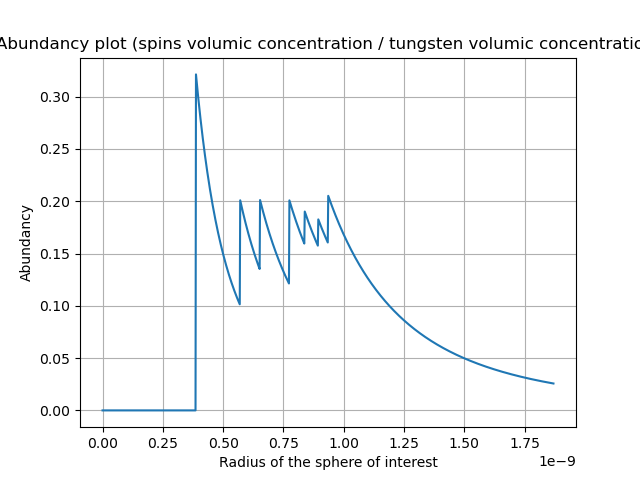

In [48]:
positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]
radius = np.max(np.linalg.norm(positions-erbium_position, axis = 1))

full_sites = np.array([index_to_coord(i, max_distance, 4) for i in range(4*max_distance**3)])
full_positions = lattice_x[None,:]*full_sites[:,0][:,None] + lattice_y[None,:] * full_sites[:,1][:,None] + lattice_z[None,:] * full_sites[:,2][:,None] + lattice_s[full_sites[:,3]]

full_concentration = 4/(a*c*a)


r = np.linspace(0.1e-30, 2*radius, 1000)

nn = np.array([np.sum(np.linalg.norm(positions-erbium_position, axis = 1) < ra) for ra in r])

fig, ax = plt.subplots(1)

ax.set_title("Abundancy plot (spins volumic concentration / tungsten volumic concentration)")

ax.set_xlabel("Radius of the sphere of interest")
ax.set_ylabel("Abundancy")
ax.grid()

ax.plot(r, nn/(4/3*np.pi*r**3)/4*a*a*c)

In [57]:
r = np.max(np.linalg.norm(positions-erbium_position, axis = 1))
N = (4/3*np.pi*r**3)*4/a/a/c
from scipy.special import binom

sum((binom(round(N)-1, k)*(0.14**k)*(1-0.14)**(round(N)-1-k) for k in range(9, round(N)))), N

(np.float64(0.13880450833783298), np.float64(43.72756042861377))

### Reconstruction visualisations

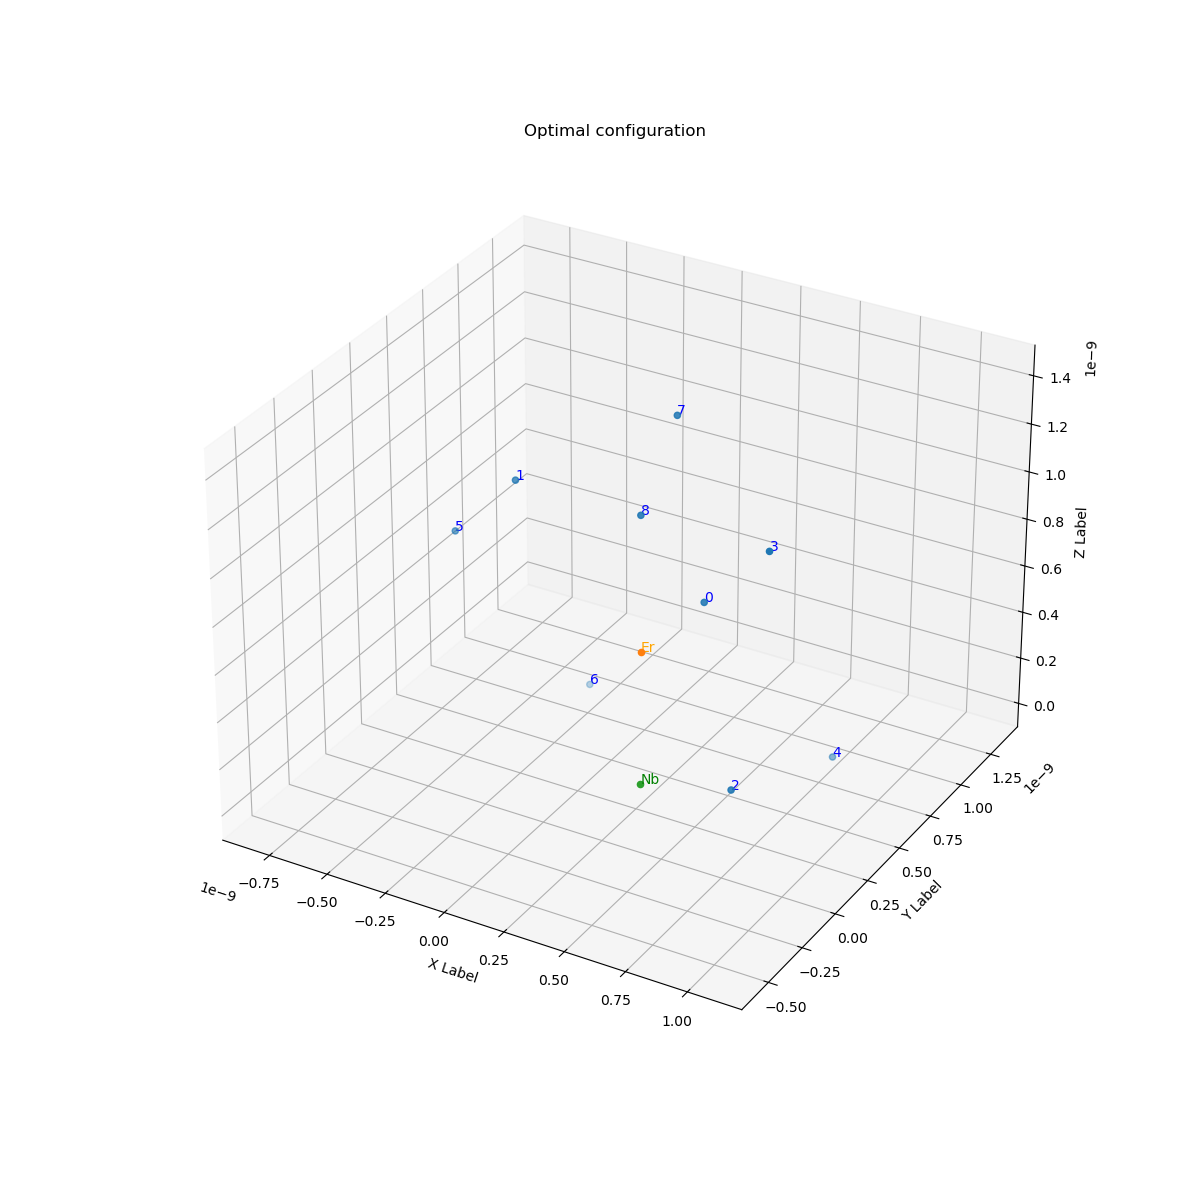

In [32]:
%matplotlib widget

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.set_title(f"Optimal configuration")
sites = np.array([index_to_coord(i, max_distance, 4) for i in selected_site], dtype = np.int64)
positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]


ax.scatter(positions[:,0], positions[:,1], positions[:,2])

ax.scatter(0.5*a, 0.5*a, 0.5*c)
ax.scatter(0.5*a, 0.5*a, 0)
ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")


for i in range(len(positions)):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
pass


### Comparing reconstructed data to real data

In [27]:
reconstructed_couplings = np.array([[all_couplings[i, j] for j in selected_site] for i in selected_site])


In [30]:
def plot_comparison_table(meas, sim, cmap='jet', labels = [], title='Measurement vs Simulation Comparison'):
    """
    Plots an NxN comparison table with a 2:1 figure aspect ratio.
    Cells with NaN in either measurement or simulation are left uncolored.

    Is this a better implem or the same ? => https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    """
    N = meas.shape[0]
    M = meas.shape[1]
    # Compute absolute discrepancies, ignoring NaNs for normalization
    diff = np.abs(meas - sim)
    norm = plt.Normalize(vmin=np.nanmin(diff), vmax=5000) #np.nanmax(diff))
    cmap = plt.get_cmap(cmap)
    
    # Create a wider figure: width = 2 * height
    fig, ax = plt.subplots(figsize=(2 * N*0.75+0.8, M*0.75+0.8))
    ax.set_xlim(-1, N)
    ax.set_ylim(0, M)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(M+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.grid(False)

    
    
    for i in range(N):
        for j in range(min(i+1, M)):
            d = diff[i, j]
            # Skip coloring if NaN
            if np.isnan(d):
                cell_color = 'none'
            else:
                cell_color = cmap(norm(d))
            # Draw cell
            rect = plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black')
            ax.add_patch(rect)
            # Diagonal line
            ax.plot([i+1, i], [j, j+1], color='black', linewidth=1)
            # Text values (show 'nan' if NaN)
            meas_val = meas[i, j]
            sim_val = sim[i, j]
            txt_meas = f'{meas_val:.2f}' if not np.isnan(meas_val) else 'nan'
            txt_sim  = f'{sim_val:.2f}'  if not np.isnan(sim_val)  else 'nan'
            ax.text(i + 0.05, j + 0.15, txt_meas, va='top', ha='left', fontsize=10)
            ax.text(i + 0.95, j + 0.85, txt_sim,  va='bottom', ha='right', fontsize=10)
    # Colorbar (exclude NaNs)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(diff[~np.isnan(diff)])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Absolute discrepancy')
    
    ax.set_title(title)

    for k,t in enumerate(labels):
        ax.text(-0.85, k/3, t)

    plt.tight_layout()
    plt.savefig("discrepancies.svg")
    plt.show()


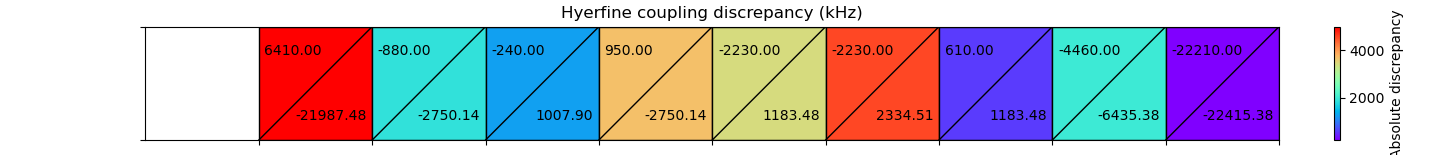

In [58]:

plot_comparison_table(a_par_data[:,None],  np.array([a_parallel[s] for s in selected_site])[:,None], title="Hyerfine coupling discrepancy (kHz)", cmap="rainbow")

In [139]:
# Generate table of couplings pair to compute for fine reconstruction
for i in range(9):
    for j in range(9):
        if not np.isnan(renormalized_data[i,j]):
            print(f"  [{i}, {j}],")

  [0, 1],
  [0, 2],
  [0, 3],
  [0, 4],
  [0, 5],
  [0, 6],
  [0, 7],
  [0, 8],
  [1, 2],
  [1, 3],
  [1, 4],
  [1, 5],
  [1, 7],
  [1, 8],
  [2, 3],
  [2, 4],
  [2, 5],
  [2, 6],
  [2, 7],
  [2, 8],
  [3, 5],
  [3, 7],
  [3, 8],


(9, 1) (9, 9)


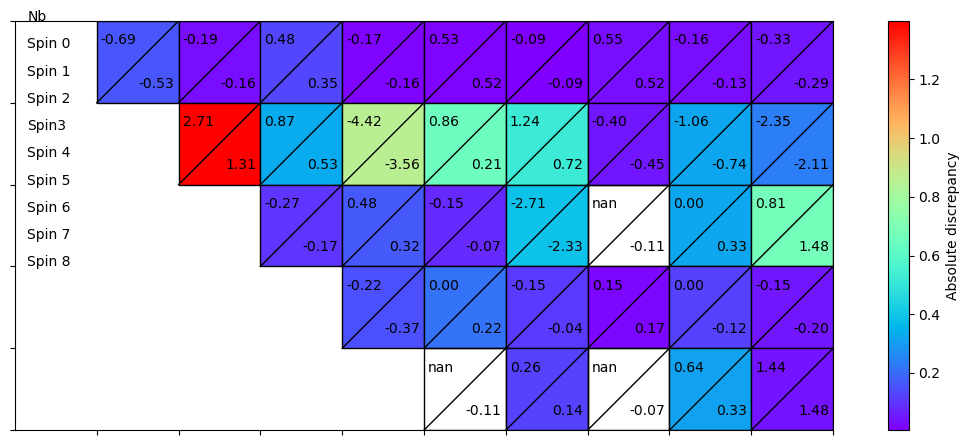

In [146]:
nb1, nb2 = nb_par_data[:,None]*gamma_ratio, np.array([nb_par[s] for s in selected_site])[:,None]*gamma_ratio
print(nb1.shape, renormalized_data.T.shape)
plot_comparison_table(np.concatenate((nb1,renormalized_data.T[:,:4]), axis = 1), np.concatenate((nb2,reconstructed_couplings[:,:4]), axis = 1), cmap="rainbow", labels = ["Nb", "Spin 0", "Spin 1", "Spin 2", "Spin3", "Spin 4", "Spin 5", "Spin 6", "Spin 7", "Spin 8"], title="")


# Solution number estimation

In [19]:
B_key = all_keys[a_par_index][n]
print(B_key)
with (
    h5py.File(file, "r") as g
):
    a_par_key = a_par_keys[a_par_index]
        
    err = g[f"{a_par_key}/Reconstructed_from_{B_key}/errors"][:]
    all_sites = g[f"{a_par_key}/Reconstructed_from_{B_key}/sites"][:]
    permut_inv = invert_permutation(g[f"{a_par_key}/Reconstructed_from_{B_key}/permutation"][:])
err[:16:4]

B_sweep_7_0


array([4.5396945 , 4.54206103, 4.56452734, 4.56563423])

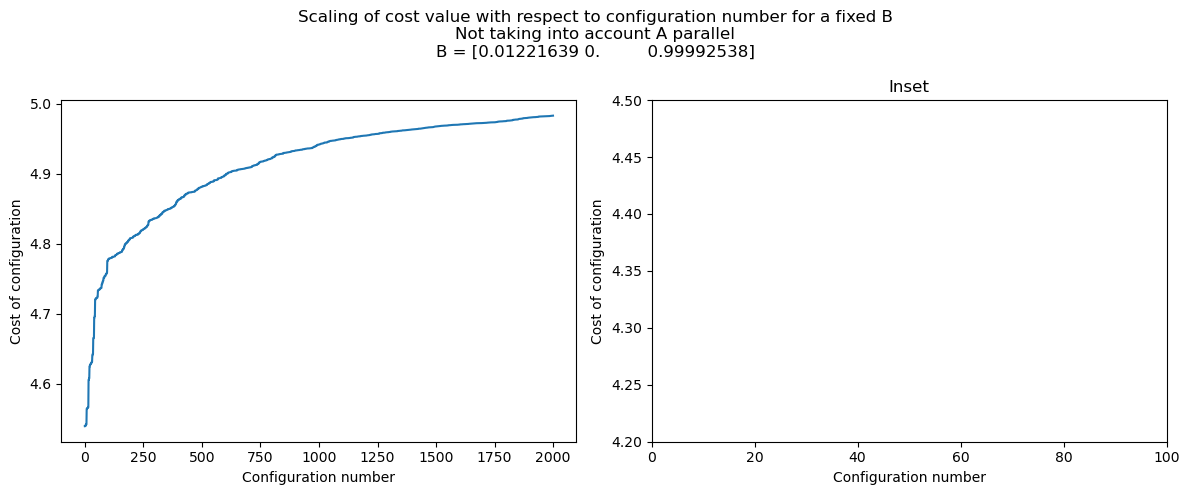

In [20]:
fig = plt.figure(figsize=(12,5))

fig.suptitle(f"Scaling of cost value with respect to configuration number for a fixed B\nNot taking into account A parallel\nB = {B}")

ax = fig.add_subplot(1,2,1)

ax.plot(range(len(err)), err)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")


ax = fig.add_subplot(1,2,2)

ax.set_title("Inset")

ax.plot(range(len(err)), err)
ax.set_xlim(0,100)
ax.set_ylim(4.2,4.5)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")
plt.tight_layout()

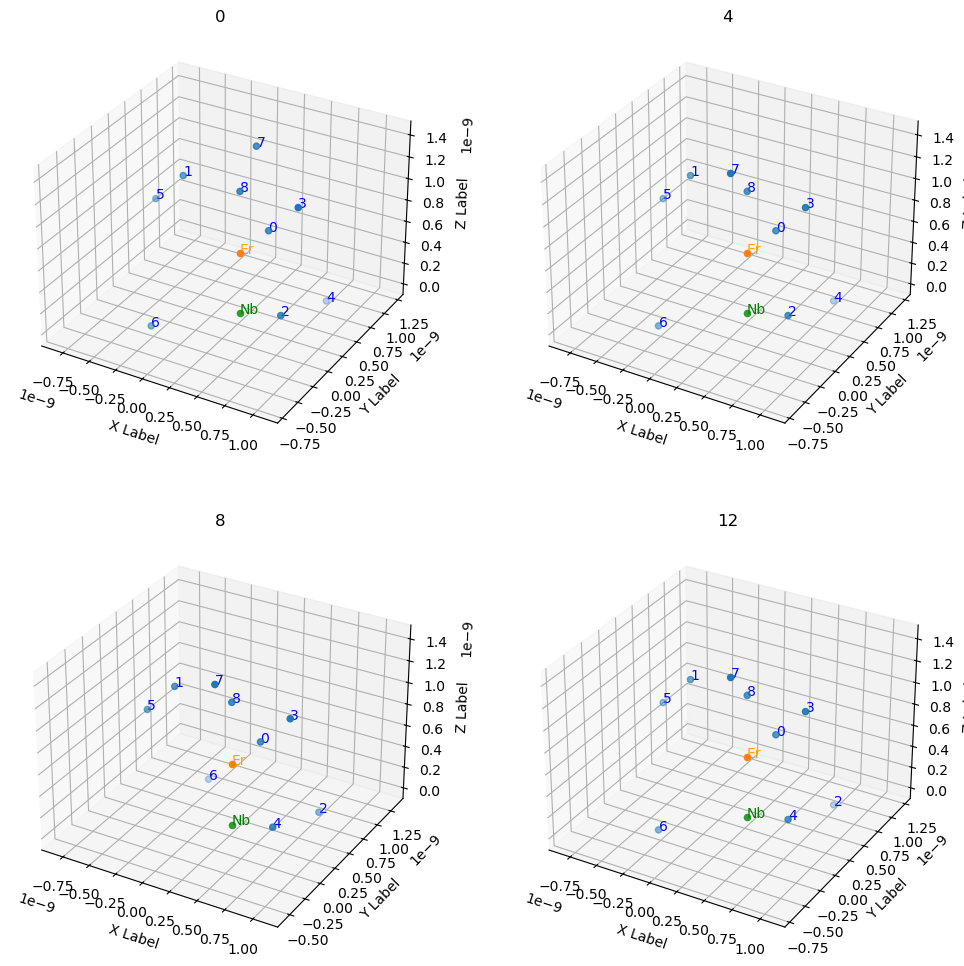

In [21]:
fig = plt.figure(figsize=(12,12))
number_of_configs_to_plot = 4
for j, m in enumerate(range(0,4 * number_of_configs_to_plot,4)):
    ax = fig.add_subplot(2,2,j+1, projection="3d")
    ax.set_title(f"{m}")
    sites = np.array([index_to_coord(i, max_distance, 4) for i in all_sites[m][permut_inv]], dtype = np.int64)
    positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]

    ax.scatter(positions[:,0], positions[:,1], positions[:,2])
    
    ax.scatter(0.5*a, 0.5*a, 0.5*c)
    ax.scatter(0.5*a, 0.5*a, 0)
    ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
    ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")
    
    
    for i in range(len(positions)):
        ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.axis('equal')


# DEPRECATED CODE

In [ ]:
config_map = np.unique(all_final_sites, axis=0)

print(f"Number of regions = {len(config_map)}")

region = np.empty(len(all_final_sites), dtype = np.uint64)

for i, conf in enumerate(config_map):
    mask = np.all(all_final_sites == conf, axis=1)
    region[mask] = i
    

fig, ax = plt.subplots()

ax.set_title("Optimal solution")

sc = ax.scatter(all_B[:,0]*180/np.pi, all_B[:,1]*180/np.pi, c=region, cmap="hsv") #levels = np.arange(len(config_map)+1) - 0.5)

n = np.argmin(all_errors)
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="red", marker="x")


n = np.argmin(np.linalg.norm(all_B[:,:2]- target_B, axis=1))
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="black", marker="x")
ax.axis("equal")
cbar = fig.colorbar(sc)
cbar.set_label("Region")